#### Задача сегментации (неформальное определение)

Разбиваем пользователей на группы, чем-то отличающиеся друг от друга

Если же более формально, то:

Сегментация клиентской базы — это способ повышения эффективности работы с пользователями путем их распределения по отдельным группам, или сегментам, в соответствии с их запросами и/или потребностями.

In [1]:
!pip install razdel

In [2]:
!pip install pymorphy2

     |████████████████████████████████| 55 kB 1.0 MB/s eta 0:00:01
     |████████████████████████████████| 8.2 MB 1.7 MB/s eta 0:00:01
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13704 sha256=bef26e6490ffa185715014987e1b3e692e2cbcd9fb74cdf57b73b4b1a224ed2c
  Stored in directory: /Users/maximcucer/Library/Caches/pip/wheels/56/ea/58/ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
Successfully built docopt


In [3]:
import pandas as pd

In [4]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [5]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [7]:
!pip install gensim

     |████████████████████████████████| 23.9 MB 4.1 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 1.5 MB/s eta 0:00:01


In [8]:
#from gensim.test.utils import common_texts
#https://webdevblog.ru/gensim-rukovodstvo-dlya-nachinajushhih/
from gensim.corpora.dictionary import Dictionary

/Users/maximcucer/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [9]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [10]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maximcucer/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [12]:
len(stopword_ru)

151

In [13]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [14]:
stopword_ru[-1]

'thru'

In [15]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    text = re.sub("n", ' ', text)

    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    #print(tokens)
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
                #print(temp_cach)
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
                #print(w,' : ',temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    #print(words_lem_without_stopwords)
    return words_lem_without_stopwords

In [16]:
list(tokenize(news.iloc[0,1][:100],   ))

[Substring(0, 11, 'Заместитель'),
 Substring(12, 24, 'председателя'),
 Substring(24, 25, 'n'),
 Substring(25, 38, 'правительства'),
 Substring(39, 41, 'РФ'),
 Substring(41, 42, 'n'),
 Substring(42, 48, 'Сергей'),
 Substring(48, 49, 'n'),
 Substring(49, 55, 'Иванов'),
 Substring(55, 56, 'n'),
 Substring(56, 62, 'избран'),
 Substring(63, 76, 'председателем'),
 Substring(77, 83, 'совета'),
 Substring(83, 84, 'n'),
 Substring(84, 87, 'ПБК'),
 Substring(88, 92, 'ЦСКА'),
 Substring(92, 93, 'n'),
 Substring(93, 94, '.'),
 Substring(95, 98, 'Как'),
 Substring(99, 100, 'с')]

In [17]:
norm_text = news.iloc[:2,1].apply(lambda x: clean_text(x), 1)
norm_text

<ipython-input-15-8769e094367c>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


0    заместитель председателя правительства рф серг...
1    матч  финала кубка россии по футболу был приос...
Name: title, dtype: object

In [ ]:
lemmatization(norm_text[0])

In [19]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

CPU times: user 24.8 s, sys: 616 ms, total: 25.4 s
Wall time: 25.8 s


In [20]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 3min 32s, sys: 3.32 s, total: 3min 36s
Wall time: 3min 45s


А теперь в 3 строчки обучим нашу модель

In [21]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [22]:
common_dictionary[4]

'банк'

Делаем BoW по списку слов

In [24]:
common_dictionary.doc2bow(['баскетбол' ,'баскетбол' ,'наше', 'все'], allow_update=True)

[(5, 2), (135645, 1), (135646, 1)]

In [25]:
common_corpus[0][0]

(0, 2)

In [26]:
len(texts[0])

113

Все просто - это словарь наших слов

Запускаем обучение

In [28]:
N_topic = 15 # число тем - гиперпараметр

In [29]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=N_topic, id2word=common_dictionary)#, passes=10)

CPU times: user 44.5 s, sys: 856 ms, total: 45.3 s
Wall time: 31.7 s


In [30]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

In [31]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(1, 0.21829744),
 (2, 0.04313166),
 (3, 0.33837476),
 (7, 0.34820512),
 (10, 0.033879638)]

In [32]:
x=lda.show_topics(num_topics=N_topic, num_words=15,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: гражданин ребёнок снижение школа украинский комиссия родитель доход закон экономика право украина народный решение социальный
topic_1: рак век бомба тур образовать популярный испания таиланд золото золотой куба пить орден фрагмент отправляться
topic_2: производитель препарат египет одежда актёр надпись майкл ньюйорк млн американский la кит сердце аркадий лосанджелес
topic_3: ребёнок статья взрыв ракета земля космос скорость воздух риск продукция произойти всё день население удар
topic_4: офицер турция авария захватить спасти бизнесмен реконструкция теория индия датчик чечня постановление мотив сражение умереть
topic_5: путин владимир медведев дмитрий россия иск восток пресссекретарить флот песок поток глава предприниматель строительство испытание
topic_6: убийство уголовный следствие преступление орган расследование законодательство следователь обвинение законопроект закон обвинять лицо приговор заключение
topic_7: новый министерство проект научный большой проверка жизнь сайт 

Очень неплохо - большинство тем вполне можно описать о чем они


построим темы 

In [33]:
news['title'].iloc[5]

['ио',
 'главное',
 'тренер',
 'вячеслав',
 'буцай',
 'прокомментировать',
 'победа',
 'югра',
 'матч',
 'регулярный',
 'чемпионат',
 'кхл',
 'прежде',
 'хотеть',
 'поблагодарить',
 'ребята',
 'команда',
 'передавать',
 'официальный',
 'сайт',
 'югра',
 'игра',
 'начинаться',
 'очень',
 'удачно',
 'пропустить',
 'гол',
 'первый',
 'смена',
 'долго',
 'входить',
 'игра',
 'связать',
 'дневный',
 'матч',
 'непривычный',
 'плюс',
 'третий',
 'матч',
 'сибирь',
 'гдеть',
 'ребята',
 'чувствовать',
 'скажем',
 'сонный',
 'второй',
 'третий',
 'период',
 'показать',
 'разбежаться',
 'играть',
 'правильно',
 'появиться',
 'момент',
 'дотерпеть',
 'заслуженно',
 'победить']

In [34]:
lda[common_dictionary.doc2bow(news['title'].iloc[1])]

[(1, 0.23295301), (3, 0.6803939), (6, 0.06559218)]

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [35]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(N_topic):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [36]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(N_topic)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(N_topic)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14
0,6,0.0,0.037417,0.000000,0.000000,0.0,0.0,0.051916,0.000000,0.0,0.439856,0.000000,0.463636,0.000000,0.000000,0.000000
1,4896,0.0,0.232952,0.000000,0.680396,0.0,0.0,0.065591,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,4897,0.0,0.218302,0.043166,0.338394,0.0,0.0,0.000000,0.348155,0.0,0.000000,0.033871,0.000000,0.000000,0.000000,0.000000
3,4898,0.0,0.067863,0.000000,0.000000,0.0,0.0,0.000000,0.311820,0.0,0.000000,0.000000,0.000000,0.000000,0.333052,0.277578
4,4899,0.0,0.101886,0.000000,0.000000,0.0,0.0,0.000000,0.089424,0.0,0.000000,0.000000,0.671106,0.115957,0.000000,0.000000


In [37]:
topic_matrix.head()

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14
0,6,0.0,0.037417,0.000000,0.000000,0.0,0.0,0.051916,0.000000,0.0,0.439856,0.000000,0.463636,0.000000,0.000000,0.000000
1,4896,0.0,0.232952,0.000000,0.680396,0.0,0.0,0.065591,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,4897,0.0,0.218302,0.043166,0.338394,0.0,0.0,0.000000,0.348155,0.0,0.000000,0.033871,0.000000,0.000000,0.000000,0.000000
3,4898,0.0,0.067863,0.000000,0.000000,0.0,0.0,0.000000,0.311820,0.0,0.000000,0.000000,0.000000,0.000000,0.333052,0.277578
4,4899,0.0,0.101886,0.000000,0.000000,0.0,0.0,0.000000,0.089424,0.0,0.000000,0.000000,0.671106,0.115957,0.000000,0.000000


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

#### векторные представления пользователей

In [38]:
users.head(10)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"
3,u101138,"[5933, 6186, 5055, 6977, 5206, 488389]"
4,u108248,"[707, 1144, 2532, 2928, 3133, 324592]"
5,u106662,"[323868, 323426, 324267, 322426, 324104, 1550]"
6,u105949,"[293138, 294471, 295012, 294736, 293949, 3544]"
7,u102457,"[6928, 5009, 6940, 7629, 7644, 512736]"
8,u104124,"[322838, 324699, 322991, 322120, 324327, 472331]"
9,u101386,"[7827, 6427, 7394, 7151, 6335, 487254]"


In [39]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(N_topic)]].values))

In [40]:
doc_dict[293622]

array([0.09996675, 0.02229423, 0.14711948, 0.04643873, 0.        ,
       0.07947966, 0.06810953, 0.20583098, 0.04187484, 0.        ,
       0.        , 0.        , 0.        , 0.28231272, 0.        ])

In [41]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    #print(user_vector)
    user_vector1 = np.max(user_vector, 0)  # можно не средний
    return user_vector1 #,user_vector

def get_user_embedding_mean(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    #print(user_vector)
    user_vector1 = np.mean(user_vector, 0)  # можно не средний
    return user_vector1 #,user_vector

def get_user_embedding_median(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    #print(user_vector)
    user_vector1 = np.median(user_vector, 0)  # можно не средний
    return user_vector1 #,user_vector

In [42]:
user_articles_list = users['articles'].iloc[33]

In [43]:
vv = get_user_embedding_max(user_articles_list)
vv

array([0.51725131, 0.11298499, 0.0293515 , 0.07537486, 0.        ,
       0.51216447, 0.47130501, 0.02875073, 0.01395029, 0.36194807,
       0.16290191, 0.73313242, 0.0615635 , 0.46944791, 0.09946848])

In [44]:
import matplotlib.pyplot as plt

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [45]:
#users['articles'].iloc[33]

In [46]:
#" ".join(news[news['doc_id']==323186]['title'].iloc[0])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [63]:
user_embeddings_max = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x), 1)])
user_embeddings_max.columns = ['topic_{}'.format(i) for i in range(N_topic)]
user_embeddings_max['uid'] = users['uid'].values
user_embeddings_max = user_embeddings_max[['uid']+['topic_{}'.format(i) for i in range(N_topic)]]
user_embeddings_max.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14
0,u105138,0.371466,0.257605,0.147119,0.179061,0.000000,0.106399,0.068110,0.423658,0.063695,0.336129,0.000000,0.489331,0.103892,0.288808,0.041971
1,u108690,0.143845,0.024616,0.000000,0.161076,0.035961,0.084139,0.137801,0.093860,0.000000,0.425137,0.000000,0.558360,0.124843,0.373572,0.036836
2,u108339,0.059778,0.263896,0.000000,0.175839,0.027231,0.032435,0.191566,0.175412,0.051370,0.338112,0.053851,0.507272,0.164713,0.442850,0.098518


In [64]:
user_embeddings_mean = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_mean(x), 1)])
user_embeddings_mean.columns = ['topic_{}'.format(i) for i in range(N_topic)]
user_embeddings_mean['uid'] = users['uid'].values
user_embeddings_mean = user_embeddings_mean[['uid']+['topic_{}'.format(i) for i in range(N_topic)]]
user_embeddings_mean.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14
0,u105138,0.138604,0.060241,0.02452,0.046564,0.000000,0.037547,0.016972,0.163448,0.022532,0.182822,0.000000,0.121646,0.033830,0.114906,0.018756
1,u108690,0.065405,0.004103,0.00000,0.060764,0.011481,0.033619,0.034364,0.045659,0.000000,0.131824,0.000000,0.318513,0.035415,0.235357,0.017357
2,u108339,0.028792,0.046956,0.00000,0.060755,0.008543,0.005406,0.072525,0.056293,0.014251,0.174317,0.018543,0.224082,0.073627,0.184041,0.023642


In [65]:
user_embeddings_median = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_median(x), 1)])
user_embeddings_median.columns = ['topic_{}'.format(i) for i in range(N_topic)]
user_embeddings_median['uid'] = users['uid'].values
user_embeddings_median = user_embeddings_median[['uid']+['topic_{}'.format(i) for i in range(N_topic)]]
user_embeddings_median.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14
0,u105138,0.049983,0.020848,0.0,0.023219,0.000000,0.019702,0.000000,0.102915,0.014813,0.231364,0.000000,0.000000,0.000000,0.059157,0.015477
1,u108690,0.066468,0.000000,0.0,0.033846,0.000000,0.019663,0.014566,0.037354,0.000000,0.036260,0.000000,0.303005,0.022997,0.246132,0.018545
2,u108339,0.029898,0.000000,0.0,0.034094,0.005545,0.000000,0.066570,0.037460,0.000000,0.200213,0.010928,0.213769,0.073576,0.141391,0.009057


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [66]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [67]:
X_max = pd.merge(user_embeddings_max, target, 'left')
X_max.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,churn
0,u105138,0.371466,0.257605,0.147119,0.179061,0.000000,0.106399,0.068110,0.423658,0.063695,0.336129,0.000000,0.489331,0.103892,0.288808,0.041971,0
1,u108690,0.143845,0.024616,0.000000,0.161076,0.035961,0.084139,0.137801,0.093860,0.000000,0.425137,0.000000,0.558360,0.124843,0.373572,0.036836,1
2,u108339,0.059778,0.263896,0.000000,0.175839,0.027231,0.032435,0.191566,0.175412,0.051370,0.338112,0.053851,0.507272,0.164713,0.442850,0.098518,1


In [68]:
X_mean = pd.merge(user_embeddings_mean, target, 'left')
X_mean.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,churn
0,u105138,0.138604,0.060241,0.02452,0.046564,0.000000,0.037547,0.016972,0.163448,0.022532,0.182822,0.000000,0.121646,0.033830,0.114906,0.018756,0
1,u108690,0.065405,0.004103,0.00000,0.060764,0.011481,0.033619,0.034364,0.045659,0.000000,0.131824,0.000000,0.318513,0.035415,0.235357,0.017357,1
2,u108339,0.028792,0.046956,0.00000,0.060755,0.008543,0.005406,0.072525,0.056293,0.014251,0.174317,0.018543,0.224082,0.073627,0.184041,0.023642,1


In [69]:
X_median = pd.merge(user_embeddings_median, target, 'left')
X_median.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,churn
0,u105138,0.049983,0.020848,0.0,0.023219,0.000000,0.019702,0.000000,0.102915,0.014813,0.231364,0.000000,0.000000,0.000000,0.059157,0.015477,0
1,u108690,0.066468,0.000000,0.0,0.033846,0.000000,0.019663,0.014566,0.037354,0.000000,0.036260,0.000000,0.303005,0.022997,0.246132,0.018545,1
2,u108339,0.029898,0.000000,0.0,0.034094,0.005545,0.000000,0.066570,0.037460,0.000000,0.200213,0.010928,0.213769,0.073576,0.141391,0.009057,1


In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [71]:
#разделим данные на train/test
X_max_train, X_max_test, y_max_train, y_max_test = train_test_split(X_max[['topic_{}'.format(i) for i in range(N_topic)]], 
                                                    X_max['churn'], random_state=0, test_size=0.25)

In [72]:
X_mean_train, X_mean_test, y_mean_train, y_mean_test = train_test_split(X_mean[['topic_{}'.format(i) for i in range(N_topic)]], 
                                                    X_mean['churn'], random_state=0, test_size=0.25)

In [73]:
X_median_train, X_median_test, y_median_train, y_median_test = train_test_split(X_median[['topic_{}'.format(i) for i in range(N_topic)]], 
                                                    X_median['churn'], random_state=0, test_size=0.25)

In [75]:
logreg_max = LogisticRegression(C=1.0)
#обучим наш пайплайн
logreg_max.fit(X_max_train, y_max_train)

LogisticRegression()

In [76]:
logreg_mean = LogisticRegression(C=1.0)
#обучим наш пайплайн
logreg_mean.fit(X_mean_train, y_mean_train)

LogisticRegression()

In [77]:
logreg_median = LogisticRegression(C=1.0)
#обучим наш пайплайн
logreg_median.fit(X_median_train, y_median_train)

LogisticRegression()

In [83]:
#наши прогнозы для тестовой выборки
preds_max = logreg_max.predict_proba(X_max_test)[:, 1]
preds_max[:10]

array([0.34261238, 0.00365875, 0.80387875, 0.15713365, 0.00687241,
       0.06139138, 0.08296999, 0.38117534, 0.00546903, 0.02175787])

In [84]:
#наши прогнозы для тестовой выборки
preds_mean = logreg_mean.predict_proba(X_mean_test)[:, 1]
preds_mean[:10]

array([0.06052062, 0.07417171, 0.61231169, 0.25745899, 0.05237126,
       0.1365613 , 0.27003977, 0.03623225, 0.0650975 , 0.06787627])

In [85]:
#наши прогнозы для тестовой выборки
preds_median = logreg_median.predict_proba(X_median_test)[:, 1]
preds_median[:10]

array([0.02941211, 0.05002575, 0.73267502, 0.34828684, 0.02861663,
       0.04375239, 0.14389734, 0.04342053, 0.10010462, 0.1527936 ])

In [86]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

Рассчитаем Precision, Recall, F_score

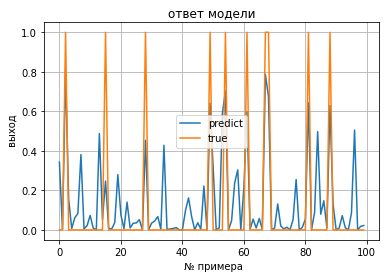

In [89]:

plt.plot( preds_max[:100], label = 'predict')
plt.plot(y_max_test.values[:100], label = 'true')
plt.title('ответ модели')
plt.xlabel(' № примера')
plt.ylabel(' выход')
plt.legend()
plt.grid('On')
plt.show()

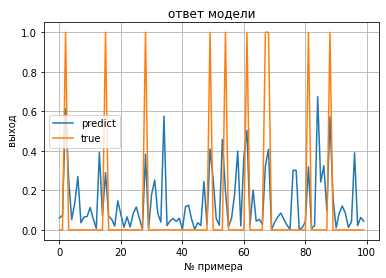

In [90]:
plt.plot( preds_mean[:100], label = 'predict')
plt.plot(y_mean_test.values[:100], label = 'true')
plt.title('ответ модели')
plt.xlabel(' № примера')
plt.ylabel(' выход')
plt.legend()
plt.grid('On')
plt.show()

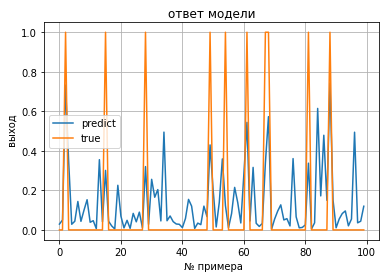

In [91]:
plt.plot( preds_median[:100], label = 'predict')
plt.plot(y_median_test.values[:100], label = 'true')
plt.title('ответ модели')
plt.xlabel(' № примера')
plt.ylabel(' выход')
plt.legend()
plt.grid('On')
plt.show()

In [92]:
np.where(precision == 0)[0]

array([], dtype=int64)

In [103]:
precision_max, recall_max, thresholds_max = precision_recall_curve(y_max_test.values[:1000], preds_max[:1000])

fscore_max = (2 * precision_max * recall_max) / (precision_max + recall_max)

# locate the index of the largest f score
ix_max = np.argmax(fscore_max)
print('(max) Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

(max) Best Threshold=0.073602, F-Score=0.461, Precision=0.300, Recall=0.992


In [104]:
precision_mean, recall_mean, thresholds_mean = precision_recall_curve(y_mean_test.values[:1000], preds_mean[:1000])

fscore_mean = (2 * precision_mean * recall_mean) / (precision_mean + recall_mean)

# locate the index of the largest f score
ix_mean = np.argmax(fscore_mean)
print('(mean) Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

(mean) Best Threshold=0.073602, F-Score=0.461, Precision=0.300, Recall=0.992


In [105]:
precision_median, recall_median, thresholds_median = precision_recall_curve(y_median_test.values[:1000], preds_median[:1000])

fscore_median = (2 * precision_median * recall_median) / (precision_median + recall_median)

# locate the index of the largest f score
ix_median = np.argmax(fscore_median)
print('(median) Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

(median) Best Threshold=0.073602, F-Score=0.461, Precision=0.300, Recall=0.992


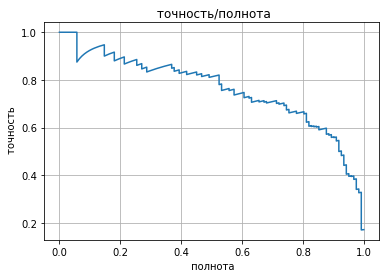

In [98]:
plt.plot(recall_max,precision_max )
plt.title(' точность/полнота')
plt.xlabel(' полнота')
plt.ylabel(' точность')
plt.grid('On')
plt.show()

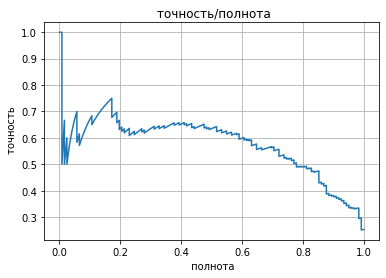

In [99]:
plt.plot(recall_mean, precision_mean)
plt.title(' точность/полнота')
plt.xlabel(' полнота')
plt.ylabel(' точность')
plt.grid('On')
plt.show()

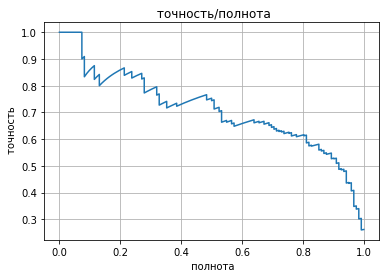

In [100]:
plt.plot(recall_median,precision_median)
plt.title(' точность/полнота')
plt.xlabel(' полнота')
plt.ylabel(' точность')
plt.grid('On')
plt.show()

In [101]:
import itertools

In [102]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() 
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1647  108]
 [  53  192]]


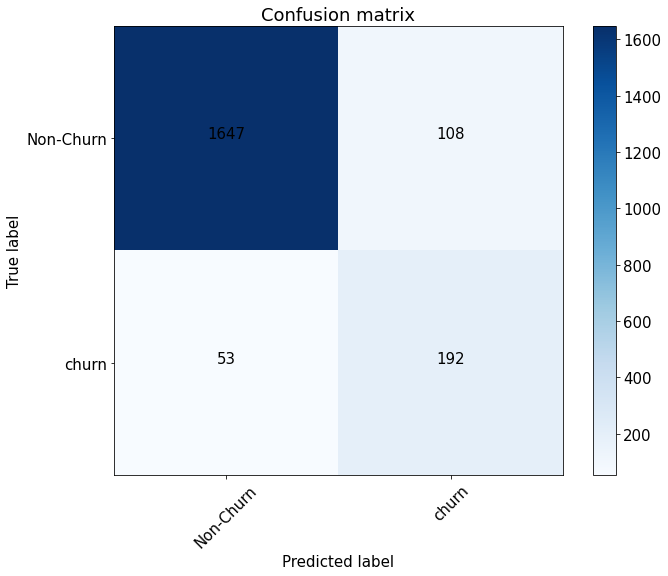

In [106]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_max_test, preds_max>thresholds[ix_max])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [107]:
roc_auc_score(y_max_test, preds_max)

0.9516297459154602

In [108]:
roc_auc_score(y_mean_test, preds_mean)

0.9330309901738473

In [109]:
roc_auc_score(y_median_test, preds_median)

0.9499552299552299

Можно заметить что способ с средними значениями и медианами показали метрики ниже чем максимальное значение, но RECALL в отличии от
остальных оказался выше. Можно сделать вывод о том что в каких-то задачах где нужно оптимизировать именно recall, эти варианты 
построения embedding могут сработать лучше.